# **Homework 07**

# **Preparations!**

## **Mounting the Drive**

In [18]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Custom print function!**

In [ ]:

######
# Define the rtf/txt file path
output_file_path = "HMW_07/output.txt"

# Open output file in write mode and clear its contents (if it exists)
output_file = open(output_file_path, 'w')
output_file.close()  # This will clear the contents if the file already exists

# Reopen the output file in append mode to keep it open
output_file = open(output_file_path, 'a')

# Define a custom "pseudo personal print" function
def perprint(message, end = '\n', file = output_file):
    print(message, end = end)
    print(message, end = end, file = file)
######

perprint("\nStarting...\n")



Starting...



# **Getting started now!**

Packages allowed in this assignment:

You are only allowed to use numpy, scipy.spatial.distance, and I/O related functions (like cv2.imread(), csv, matplotlib etc.). Official introductions can be found online.

Important: scikit-learn and SciPy is not allowed.

# **I. Kernel Eigenfaces / Fisherfaces**

In this section, you are going to do face recognition using eigenface and fisherface.

Reference: https://faculty.ucmerced.edu/mhyang/papers/fg02.pdf

## **Paths and directories for input and output files!**

In [ ]:
import os
""" I. Kernel Eigenfaces / Fisherfaces """
# Variables for input directories
training_folder = 'HMW_07/Yale_Face_Database/Training'
testing_folder = 'HMW_07/Yale_Face_Database/Testing'

# Variable for output directory
output_folder = 'HMW_07/Kernel_Eigenfaces_Fisherfaces'

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)


## **Import Packages!**

In [5]:

import os, time
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.spatial.distance import cdist


## **All functions!**

In [6]:

############# Part 1 & 2 #############


def read_dataset(directory, SHAPE):
    """
    Reads a dataset of images, resizes them, and flattens them into vectors.

    Parameters:
    directory (str): The path to the directory containing the images.
    SHAPE (tuple): The desired shape (width, height) for resizing the images.

    Returns:
    tuple: A tuple containing the flattened image data and their labels.
    """

    ''' List all files in the directory '''
    files = os.listdir(directory)

    ''' Initialize arrays for storing image data and labels '''
    images = np.zeros((len(files), SHAPE[0]*SHAPE[1]), dtype=np.float32) # Default is float64, more memory
    labels = np.zeros(len(files), dtype=int)

    ''' Process each file in the directory '''
    for i, file in enumerate(files):
        with Image.open(os.path.join(directory, file)) as image:
            ''' Resize the image with high-quality downsampling '''
            image = image.resize(SHAPE, Image.LANCZOS)

            ''' Flatten the image and store it in the array '''
            images[i] = np.asarray(image, dtype=np.float32).flatten()

            ''' Extract label from the filename and store it '''
            labels[i] = int(file[7:9])

    return images, labels


def show_save_faces(faces, rows, title, save_dir=None):
    """
    Display a grid of images and optionally save the figure.

    Args:
    - faces: List of images (2D arrays) to be displayed.
    - rows: Number of rows in the grid layout.
    - title: Title of the figure.
    - save_dir: Directory where the figure should be saved (optional).

    Returns:
    - None
    """
    plt.figure(title)
    num_faces = len(faces)
    ''' Calculate the number of columns to accommodate all images using NumPy '''
    cols = int(np.ceil(num_faces / rows))
    for idx, face in enumerate(faces):
        plt.subplot(rows, cols, idx + 1)
        plt.axis('off')
        plt.imshow(face, cmap='gray')

    ''' Save the figure if save_dir is specified '''
    if save_dir:
        file_path = os.path.join(save_dir, f'{title}.png')
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

    plt.show()

    return


def face_recognition(train_labels, train_projections, test_labels, test_projections, k=5, title=''):
    '''
    Face Recognition using k-Nearest Neighbors (KNN)

    Parameters:
        train_label (numpy.ndarray): Labels of the training samples.
        train_projections (numpy.ndarray): Feature weights (representations) of the training samples.
        test_label (numpy.ndarray): Labels of the test samples.
        test_projections (numpy.ndarray): Feature weights (representations) of the test samples.
        k (int, optional): Number of nearest neighbors to consider in KNN. Default is 5.
        title (str, optional): Title for result display. Default is an empty string.

    Returns:
        accuracy (int)

    Description:
        This function performs face recognition using the k-Nearest Neighbors (KNN) algorithm. It calculates the
        accuracy of the recognition process and prints the result.

        - The `train_label` and `train_projections` parameters contain the labels and feature weights of the training samples.
        - The `test_label` and `test_projections` parameters contain the labels and feature weights of the test samples.
        - The `k` parameter specifies the number of nearest neighbors to consider in KNN (default is 5).
        - The `title` parameter is an optional title for result display.

        The function calculates the accuracy of the recognition process by comparing the predicted labels for the test
        samples to their true labels. It then prints the accuracy as a percentage.
    '''


    ''' Initialize a variable to keep track of prediction errors '''
    error = 0
    ''' Create an array to store distances between test and train samples '''
    dist = np.zeros(len(train_projections))

    ''' Loop through each test sample '''
    for i in range(len(test_projections)):
        ''' Calculate squared Euclidean distance between test[i] and train samples '''
        dist = cdist([test_projections[i]], train_projections, 'sqeuclidean')

        ''' Find the indices of the k=5 nearest neighbors in the training set '''
        k_nearest = np.argsort(dist)[0][0:k]

        ''' Predict the label of the test sample based on the most frequent label among k nearest neighbors '''
        predict = np.argmax(np.bincount(train_labels[k_nearest]))

        ''' Check if the predicted label does not match the true label of the test sample '''
        if test_labels[i] != predict:
            error += 1

    ''' Calculate and print the accuracy by comparing the total number of samples with the number of errors '''
    accuracy = (len(test_labels) - error) / len(test_labels)
    perprint(f"K= {k}, {title}Accuracy: {accuracy*100:.2f} % ")

    return accuracy


def PCA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, output_folder):
    """
      Principal Component Analysis (PCA) for Face Recognition

      This function performs PCA for face recognition using training and testing datasets of face images. It involves computing eigenfaces (principal components) and using them for dimensionality reduction and face reconstruction.

      Parameters:
      - train_images: A numpy 2D array containing the training face images.
      - test_images: A numpy 2D array containing the test face images.
      - train_labels: A numpy array of labels corresponding to the training images.
      - test_labels: A numpy array of labels corresponding to the test images.
      - SHAPE: A tuple representing the dimensions (width, height) of the face images.
      - chosen_index: Indices for selecting random 10 test images for reconstruction.
      - output_folder: The path to the folder for saving intermediate results (eigenvalues, eigenvectors, visualizations).

      Workflow:
      1. Average Face Calculation: Computes the mean face from the training dataset.
      2. Data Centering: Subtracts the average face from each training image.
      3. Covariance Matrix Computation: Calculates the covariance matrix of the centered training data.
      4. Eigenvalue Decomposition: Obtains eigenvalues and eigenvectors (eigenfaces) from the covariance matrix.
      5. Eigenface Selection: Selects the top 25 eigenfaces based on eigenvalues.
      6. Eigenface Visualization: Displays and saves the eigenfaces.
      7. Test Image Projection: Projects selected test images onto the eigenfaces to get their representations in the reduced space.
      8. Test Image Reconstruction: Reconstructs selected test images using the eigenfaces.
      9. projections Calculation: Computes projections for both training and test images in the reduced space.
      10. Face Recognition: Performs k-nearest neighbors (k-NN) classification for face recognition using the computed projections.

      The function includes steps for visualizing the eigenfaces and reconstructed faces, and saves the intermediate results for future use.

      Returns:
      - There is no direct return value, but the function performs several operations including visualizations and accuracy calculations for face recognition.
    """


    ''' Calculate the average face from training images '''
    avg_face = np.mean(train_images, axis=0)
    ''' Center the training data: substract the average face/image '''
    centered_train_faces = train_images - avg_face

    '''
    Load the eigenvalues and eigenvectors if they already exist
    otherwise:
    Compute the kernel matrix first, of shape SHAPE[0]*SHAPE[1] X SHAPE[0]*SHAPE[1]
    '''
    # File paths
    eigen_vectors_file = os.path.join(output_folder, "PCA_eigen_vectors.npy")
    eigen_values_file = os.path.join(output_folder, "PCA_eigen_values.npy")

    if os.path.exists(eigen_vectors_file) and os.path.exists(eigen_values_file):
        print(f"\nFound eigenvalues and eigenvectors for PCA. \nLoading ... \n")
        eigen_vectors = np.load(eigen_vectors_file)
        eigen_values = np.load(eigen_values_file)
    else:
        print(f"\nDidn't find eigenvalues and eigenvectors for PCA. \nComputing ... \n")

        ''' Compute the covariance matrix, unbiased '''
        Cov_matrix = np.dot(centered_train_faces.T, centered_train_faces) / (len(train_images) - 1)

        ''' Perform eigenvalue decomposition to obtain eigenvalues and eigenvectors '''
        eigen_values, eigen_vectors = np.linalg.eig(Cov_matrix)

        # Save eigenvalues and eigenvectors
        np.save(eigen_vectors_file, eigen_vectors)
        np.save(eigen_values_file, eigen_values)

    ''' Projection matrix (W from class):
    Sort eigenvalues in descending order and select the top 25 eigenvectors (eigenfaces) '''
    sort_index = np.argsort(-eigen_values)
    top_eigen_vectors = eigen_vectors[:, sort_index[0:25]].real # Projection matrix W

    ''' Here we have our eigenfaces, 25 in total, 1 on each row'''
    eigenfaces = top_eigen_vectors.T # Shape = (25, SHAPE[0]*SHAPE[1])

    ''' Visualize the eigenfaces (reshape and display) '''
    show_save_faces(eigenfaces.reshape(25, SHAPE[1], SHAPE[0]), 5, 'PCA eigenfaces', output_folder)

    ''' Projecting the centered test images onto the PCA eigenvectors to obtain projections '''
    test_images_centered = test_images[chosen_index] - avg_face
    projections = np.dot(test_images_centered, eigenfaces.T) # AKA projected centered data

    ''' Reconstruct the selected test images using the eigenfaces '''
    reconstruction_faces = avg_face + np.dot(projections, eigenfaces) # Need to add the average to get the right reconstruction

    ''' Visualize the reconstructed faces'''
    show_save_faces(reconstruction_faces.reshape(10, SHAPE[1], SHAPE[0]), 2, 'PCA reconstructed faces', output_folder)

    ''' Calculate projections for both centered training and centered test images '''
    train_projections = np.dot(centered_train_faces, eigenfaces.T)
    centered_test_faces = test_images - avg_face
    test_projections = np.dot(centered_test_faces, eigenfaces.T)

    ''' Perform face recognition using the calculated projections '''
    perprint("")
    accuracy_list = []  # List to store accuracies for each k_neighbors
    for k_neighbors in range(1, 13):
        accuracy = face_recognition(train_labels, train_projections, test_labels, test_projections, k_neighbors, title='PCA ')
        accuracy_list.append(accuracy)
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    perprint(f"\nAverage: {average_accuracy*100:.2f} % \n")

    return


def LDA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, output_folder, top):
    """
      Linear Discriminant Analysis (LDA) for Face Recognition

      This function applies LDA to face recognition, involving steps from computing average faces to performing classification based on facial features. It includes dimensionality reduction through PCA before applying LDA, which helps in handling the high dimensionality of face images.

      Parameters:
      - train_images (numpy.ndarray): Array of training face images.
      - test_images (numpy.ndarray): Array of test face images.
      - train_labels (numpy.ndarray): Labels corresponding to the training images.
      - test_labels (numpy.ndarray): Labels corresponding to the test images.
      - SHAPE (tuple): Dimensions (height, width) of the face images.
      - chosen_index (list): Indices of the test images selected for detailed analysis and reconstruction.
      - output_folder (str): Path to the folder for saving output files (eigenvalues, eigenvectors, visualizations).
      - top (int): Number of top eigenvectors to select in PCA.

      Workflow:
      1. Average Face Calculation: Computes the mean face from the training dataset.
      2. Image Centering: Subtracts the average face from each training image.
      3. PCA Dimensionality Reduction: Applies PCA to reduce image data dimensionality, aiding LDA's effectiveness.
      4. Scatter Matrix Calculation: Calculates both within-class and between-class scatter matrices.
      5. Fisherfaces Creation: Determines Fisherfaces by finding eigenvalues and eigenvectors from the scatter matrix ratio.
      6. Fisherfaces Visualization: Visualizes Fisherfaces for analysis and insight.
      7. Test Image Projection: Projects selected test images onto Fisherfaces space to obtain their reduced representations.
      8. Image Reconstruction: Reconstructs test images using Fisherfaces, which helps in visualizing the results of LDA.
      9. Face Recognition: Executes face classification by comparing the features of training and test images, using a k-nearest neighbors (k-NN) algorithm for classification.

      The function includes comprehensive steps for visualizing the process and intermediate results, along with performance evaluation in terms of classification accuracy.

      Returns:
      - The function does not have a direct return value, but it performs a range of operations, including visualizations, dimensionality reduction, and face recognition.
    """


    ''' Calculate the average face from training images '''
    avg_face = np.mean(train_images, axis=0)
    ''' Center the training images '''
    train_images_centered = train_images - avg_face

    # Load and Select the top 25 PCA eigenvectors
    eigen_vectors_pca = np.load(os.path.join(output_folder, "PCA_eigen_vectors.npy"))
    eigen_values_pca = np.load(os.path.join(output_folder, "PCA_eigen_values.npy"))
    sort_index_pca = np.argsort(-eigen_values_pca)
    top_eigen_vectors_pca = eigen_vectors_pca[:, sort_index_pca[0:top]]

    ''' Project Training Data onto PCA Space to reduce its dimension before LDA '''
    X_pca = np.dot(train_images_centered, top_eigen_vectors_pca) # eigenface.T = top_eigen_vectors_pca

    '''
    Apply LDA on PCA-transformed Data
    '''
    start_time_ = time.time() ##########

    ''' Number of unique classes '''
    num_classes = len(np.unique(train_labels))

    ''' Number of features (SHAPE[0]*SHAPE[1]) '''
    num_features = X_pca.shape[1]  # = 126, optimal
    print(f"X_pca.shape = {X_pca.shape}, and {X_pca.shape[1]}")

    ''' Initialize Within-Class Scatter (variance) Matrix '''
    S_W = np.zeros((num_features, num_features))
    ''' Initialize Between-Class Scatter (variance) Matrix '''
    S_B = np.zeros((num_features, num_features))

    '''
    Calculate scatter matrices:
    '''
    overall_mean = np.mean(X_pca, axis=0)
    for i in range(1, num_classes+1): # Be careful with the range
        class_indices = np.where(train_labels == i)[0]
        X_class = X_pca[class_indices]
        class_mean = np.mean(X_class, axis=0)
        ''' Calculate Scatter Matrix for class i (SWi) '''
        S_W += np.dot((X_class - class_mean).T, (X_class - class_mean))

        N_i = X_class.shape[0]
        mean_diff = (class_mean - overall_mean).reshape(num_features, 1)
        ''' Calculate Scatter Matrix between class means (S_Bi) '''
        S_B += N_i * (mean_diff).dot(mean_diff.T)

    ''' Compute (S_W ^-1) .dot(S_B) '''
    ratio_B_W = np.dot( np.linalg.inv(S_W), S_B)
    perprint(f"\nRatio (S_W^-1).S_B computed in {int(round(time.time() - start_time_))} seconds")#############
    start_time_ = time.time() ##########

    ''' Perform eigenvalue decomposition to obtain eigenvalues and eigenvectors '''
    eigen_values_lda, eigen_vectors_lda = np.linalg.eig(ratio_B_W) # Can comment out (1)
    perprint(f"eigenvalue decomposition computed in {int(round(time.time() - start_time_))} seconds \n")#############

    ''' Save the eigenvalues and eigenvectors for later use '''
    np.save(os.path.join(output_folder, "LDA_eigen_vectors.npy"), eigen_vectors_lda)  # Can comment out (1)
    np.save(os.path.join(output_folder, "LDA_eigen_values.npy"), eigen_values_lda)  # Can comment out (1)
    ''' Load eigenvalues and eigenvectors for rapid code testing '''
    eigen_vectors_lda = np.load(os.path.join(output_folder, "LDA_eigen_vectors.npy"))
    eigen_values_lda = np.load(os.path.join(output_folder, "LDA_eigen_values.npy"))

    ''' Projection matrix (W from class):
    reorder, the matrix is top*top, but can select top 25 eigenvectors '''
    sort_index_lda = np.argsort(-eigen_values_lda)
    top_eigen_vectors_lda  = eigen_vectors_lda[:, sort_index_lda[0:25]].real # Projection matrix W

    ''' Compute Fisherfaces '''
    ''' Here we have our fisherfaces, 25 in total, 1 on each row'''
    fisherfaces = np.dot(top_eigen_vectors_pca, top_eigen_vectors_lda)
    fisherfaces = fisherfaces.T # Shape = (25, SHAPE[0]*SHAPE[1])

    ''' Visualize the eigenfaces (reshape and display) '''
    show_save_faces(fisherfaces.reshape(25, SHAPE[1], SHAPE[0]), 5, 'LDA fisherfaces', output_folder) ##########

    ''' Project the selected test images onto the eigenfaces to obtain projections '''
    centered_test_images = test_images[chosen_index] - avg_face
    projections = np.dot(centered_test_images, fisherfaces.T)

    ''' Reconstruct the selected test images using the eigenfaces '''
    reconstruction_faces = avg_face + np.dot(projections, fisherfaces)

    ''' Visualize the reconstructed faces'''
    show_save_faces(reconstruction_faces.reshape(10, SHAPE[1], SHAPE[0]), 2, 'LDA reconstructed faces', output_folder) ##########

    ''' Calculate projections for both centered training and centered test images '''
    train_projections = np.dot(train_images_centered, fisherfaces.T)
    test_faces_centered = test_images - avg_face
    test_projections = np.dot(test_faces_centered, fisherfaces.T)

    ''' Perform face recognition using the calculated projections '''
    perprint("")
    accuracy_list = []  # List to store accuracies for each k_neighbors
    for k_neighbors in range(1, 13):
        accuracy = face_recognition(train_labels, train_projections, test_labels, test_projections, k_neighbors, title='LDA ')
        accuracy_list.append(accuracy)
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    perprint(f"\nAverage: {average_accuracy*100:.2f} % \n")

    return


############# Part 3 #############


def RBF_kernel(A, B, gamma=0.1):
    return np.exp(-gamma * cdist(A, B, 'sqeuclidean')) # Just bad no matter gamma

def linearKernel(A, B):
    return np.dot(A, B.T) # Constant = 0 is best

def polynomialKernel(A, B, coef=0, degree=2, gamma=1):
    return np.power(gamma * (np.dot(A, B.T)) + coef, degree) # Higher degree gives lower performance

def compute_kernel_matrix(kernel, images1, images2):
    """
      Compute the kernel matrix between two sets of images.

      Parameters:
      kernel (str): The type of kernel to be used. Options are 'rbf', 'linear', or 'polynomial'.
      images1 (array): The first set of images, represented as an array of data (testing goes here if any).
      images2 (array): The second set of images, represented as an array of data.

      Returns:
      array: The computed kernel matrix between the two sets of images.
    """


    if kernel == 'rbf':
        return RBF_kernel(images1, images2)
    elif kernel == 'polynomial':
        return polynomialKernel(images1, images2)
    elif kernel == 'linear':
        return linearKernel(images1, images2)
    else:
      print("\nEnter a valid kernel name: 'rbf', 'linear', or 'polynomial' \n")
    return


def kernel_PCA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, kernel, output_folder):
    """
      Perform Kernel Principal Component Analysis (Kernel PCA) for face recognition.

      Parameters:
      - train_images: Array of training images.
      - test_images: Array of test images.
      - train_labels: Labels for the training images.
      - test_labels: Labels for the test images.
      - SHAPE: Tuple indicating the shape of the images (height, width).
      - chosen_index: Indices of specific test images for detailed analysis.
      - kernel: Type of kernel used in the computation.
      - output_folder: Directory path to save output files (eigenvectors, eigenvalues, visualizations).

      The function performs the following steps:
      1. Computes the average face from training images.
      2. Centers the training data by subtracting the average face.
      3. Checks if eigenvalues and eigenvectors for the specified kernel are already computed.
      4. If not present, computes the kernel matrix and its centered version.
      5. Performs eigenvalue decomposition on the centered kernel matrix.
      6. Sorts eigenvalues and computes the corresponding eigenfaces.
      7. Visualizes the eigenfaces.
      8. Projects and reconstructs selected test images.
      9. Computes the kernel matrix between test and training data.
      10. Projects training and test data for face recognition.
      11. Calculates and prints the accuracy of face recognition.
    """


    ''' Calculate the average face from training images '''
    avg_face = np.mean(train_images, axis=0)
    ''' Center the training data: substract the average face/image '''
    centered_train_faces = train_images - avg_face

    '''
    Load the eigenvalues and eigenvectors if they already exist
    otherwise:
    Compute the kernel matrix first, of shape SHAPE[0]*SHAPE[1] X SHAPE[0]*SHAPE[1]
    '''

    ''' File paths Check if the files exist '''
    eigen_vectors_file = os.path.join(output_folder, f"{kernel}_PCA_eigen_vectors.npy")
    eigen_values_file = os.path.join(output_folder, f"{kernel}_PCA_eigen_values.npy")

    if os.path.exists(eigen_vectors_file) and os.path.exists(eigen_values_file):
        print(f"\nFound eigenvalues and eigenvectors for {kernel} PCA kernel. \nLoading ... \n")
        eigen_vectors = np.real(np.load(eigen_vectors_file))
        eigen_values = np.real(np.load(eigen_values_file))
        kernel_matrix = np.load(os.path.join(output_folder, f"{kernel}_PCA_kernel_matrix.npy"))
        kernel_centered = np.load(os.path.join(output_folder, f"{kernel}_PCA_kernel_centered.npy"))
    else:
        print(f"\nDidn't find eigenvalues and eigenvectors for {kernel} PCA kernel. \nComputing ... \n")
        ''' compute kernel matrix '''
        kernel_matrix = compute_kernel_matrix(kernel, centered_train_faces, centered_train_faces)

        ''' Center the kernel matrix in the unbiased form (divide by n-1, n is number of data points) '''
        one_N = np.ones(kernel_matrix.shape) / ( kernel_matrix.shape[0] - 1 ) ########## Unbiased
        kernel_centered = (kernel_matrix
                          - np.dot(one_N, kernel_matrix)
                          - np.dot(kernel_matrix, one_N)
                          + np.dot(np.dot(one_N, kernel_matrix), one_N))
        #Save the kernel matrix centered kernel matrix
        np.save(os.path.join(output_folder, f"{kernel}_PCA_kernel_matrix.npy"), kernel_matrix)
        np.save(os.path.join(output_folder, f"{kernel}_PCA_kernel_centered.npy"), kernel_centered)

        ''' Perform eigenvalue decomposition on the centered kernel matrix '''
        eigen_values, eigen_vectors = np.linalg.eig(kernel_centered)
        eigen_vectors = np.real(eigen_vectors)
        eigen_values = np.real(eigen_values)

        # Save eigenvalues and eigenvectors
        np.save(eigen_vectors_file, eigen_vectors)
        np.save(eigen_values_file, eigen_values)


    ''' Projection matrix (W from class):
    Sort eigenvalues in descending order and select the top 25 eigenvectors (eigenfaces) '''
    sort_index = np.argsort(-eigen_values)
    sorted_eigen_vectors = eigen_vectors[:, sort_index].real

    ##############################
    ####################
    ##########
    ''' Here we have our eigenfaces, 25 in total, 1 on each row by getting eigevectors of covariance matrix from eigenvectors of kernel matrix '''
    eigenfaces = np.dot(centered_train_faces.T, sorted_eigen_vectors[:, :25])
    eigenfaces = eigenfaces.T  # Shape = (25, SHAPE[0]*SHAPE[1])

    ''' Visualize the eigenfaces (reshape and display) '''
    show_save_faces(eigenfaces.reshape(25, SHAPE[1], SHAPE[0]), 5, f'{kernel}_PCA eigenfaces', output_folder)

    ##########
    ''' Projecting the centered test images onto the 25-D by kernel PCA method '''
    test_images_chosen_centered = test_images[chosen_index] - avg_face
    # kernel_test_chosen = compute_kernel_matrix(kernel, test_images_chosen_centered, centered_train_faces)
    # kernel_test_chosen_centered = kernel_test_chosen - np.mean(kernel_test_chosen, axis = 1, keepdims=True)
    # projections_test_chosen = np.dot(kernel_test_chosen_centered, sorted_eigen_vectors[:, :25]) # AKA projected centered data, with 25-D
    ''' (Exactly Same as Above) '''
    projections_test_chosen = np.dot(test_images_chosen_centered, eigenfaces.T) # AKA projected centered data
    ##########

    ''' Reconstruct the selected test images using the eigenfaces '''
    reconstruction_faces = avg_face + np.dot(projections_test_chosen, eigenfaces) # Need to add the average to get the right reconstruction

    ''' Visualize the reconstructed faces'''
    show_save_faces(reconstruction_faces.reshape(10, SHAPE[1], SHAPE[0]), 2, f'{kernel}_PCA reconstructed faces', output_folder)
    ##########
    ####################
    ##############################

    ''' Projecting the ALL centered test and train images onto the 25-D by kernel PCA method '''
    test_images_centered = test_images - avg_face
    K_test_train = compute_kernel_matrix(kernel, test_images_centered, centered_train_faces) #########
    kernel_tain_train_centered = kernel_centered
    K_test_train_centered = K_test_train - np.mean(K_test_train, axis = 1, keepdims=True)

    ##########
    """ Projections of testing data points """
    projections_test = np.dot(K_test_train_centered, sorted_eigen_vectors[:, :25]) # AKA projected centered data, with 25-D
    """ Or exactly as below """
    # projections_test = np.dot(test_images_centered, eigenfaces.T) # AKA projected centered data, with 25-D

    ###

    """ Projections of training data points """
    projections_train = np.dot(kernel_tain_train_centered, sorted_eigen_vectors[:, :25]) # AKA projected centered data, with 25-D
    """ Or exactly as below, you can try """
    # projections_train = np.dot(centered_train_faces, eigenfaces.T) # AKA projected centered data, with 25-D
    ##########

    ''' Perform face recognition using the calculated weights '''
    accuracy_list = []  # List to store accuracies for each k_neighbors
    for k_neighbors in range(1, 13):
        accuracy = face_recognition(train_labels, projections_train, test_labels, projections_test, k_neighbors, title=f'{kernel}_PCA ')
        accuracy_list.append(accuracy)
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    perprint(f"\nAverage: {average_accuracy*100:.2f} % \n")

    return


def kernel_LDA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, kernel, output_folder):
    """
      Kernel Linear Discriminant Analysis (kernel LDA) for Face Recognition

      This function applies kernel LDA to face recognition tasks, utilizing a specified kernel method. It involves several crucial steps, each aimed at enhancing the discriminative power of the feature space for better face classification.

      Parameters:
      - train_images (numpy.ndarray): Array of training face images.
      - test_images (numpy.ndarray): Array of test face images.
      - train_labels (numpy.ndarray): Labels corresponding to the training images.
      - test_labels (numpy.ndarray): Labels corresponding to the test images.
      - SHAPE (tuple): Dimensions (height, width) of the face images.
      - chosen_index (list): Indices of the test images selected for detailed analysis and reconstruction.
      - kernel (str): The kernel method to use (e.g., 'linear', 'poly', 'rbf').
      - output_folder (str): Path to the folder for saving output files like kernel matrices and eigenvalues/eigenvectors.

      Workflow:
      1. Kernel Matrix Computation: Calculates the kernel matrix for the training data using the specified kernel method.
      2. Matrix Centering: Centers the kernel matrix to ensure the data in the feature space is mean-free.
      3. Scatter Matrix Calculation: Computes within-class and between-class scatter matrices in the kernel-induced feature space.
      4. Eigenvalue Problem: Solves the eigenvalue problem to find directions that maximize class separability.
      5. Fisherfaces Projection: Projects the training data onto the top eigenvectors (Fisherfaces) in the feature space.
      6. Visualization: Visualizes the Fisherfaces, providing insights into discriminative features.
      7. Test Image Projection and Reconstruction: Projects selected test images onto Fisherfaces and reconstructs them to evaluate the method.
      8. Face Recognition: Performs face recognition by comparing the feature weights of training and test images, assessing the method's effectiveness.

      The function optimizes processing time by checking and loading existing computations if available, making it efficient for large datasets.

      Returns:
      - The function does not have a direct return value but performs a range of operations, including visualizations, dimensionality reduction, and face recognition.
      """


    # Calculate the average face from training images
    avg_face = np.mean(train_images, axis=0)
    # Center the training data: substract the average face/image
    centered_train_faces = train_images - avg_face

    '''
    Load the eigenvalues and eigenvectors if they already exist
    otherwise:
    Compute them
    '''

    ''' File paths and check if the files exist '''
    eigen_vectors_file = os.path.join(output_folder, f"{kernel}_LDA_eigen_vectors.npy")
    eigen_values_file = os.path.join(output_folder, f"{kernel}_LDA_eigen_values.npy")

    if os.path.exists(eigen_vectors_file) and os.path.exists(eigen_values_file):
        print(f"\nFound eigenvalues and eigenvectors for {kernel} LDA kernel. \nLoading ... \n")
        eigen_vectors = np.real(np.load(eigen_vectors_file))
        eigen_values = np.real(np.load(eigen_values_file))
        Kernel_matrix_LDA = np.load(os.path.join(output_folder, f"{kernel}_LDA_kernel_matrix.npy"))
        K_centered = np.load(os.path.join(output_folder, f"{kernel}_LDA_kernel_centered.npy"))
    else:
        print(f"\nDidn't find eigenvalues and eigenvectors for {kernel} LDA kernel. \nComputing ... \n")

        ''' Step 1: Compute the Kernel Matrix for the training data '''
        Kernel_matrix_LDA = compute_kernel_matrix(kernel, train_images, train_images)

        ''' Step 2: Center the Kernel Matrix '''
        ''' Center the kernel matrix in the unbiased form (divide by n-1, n is number of data points) '''
        one_N = np.ones(Kernel_matrix_LDA.shape) / ( Kernel_matrix_LDA.shape[0] - 1 ) ########## Unbiased
        K_centered = (Kernel_matrix_LDA
                          - np.dot(one_N, Kernel_matrix_LDA)
                          - np.dot(Kernel_matrix_LDA, one_N)
                          + np.dot(np.dot(one_N, Kernel_matrix_LDA), one_N))

        # Save the kernel matrix centered kernel matrix
        np.save(os.path.join(output_folder, f"{kernel}_LDA_kernel_matrix.npy"), Kernel_matrix_LDA)
        np.save(os.path.join(output_folder, f"{kernel}_LDA_kernel_centered.npy"), K_centered)

        ''' Step 3: Compute the Scatter Matrices in the Feature Space '''
        num_classes = len(np.unique(train_labels))
        num_features = K_centered.shape[1]
        print(f"K_centered.shape: {K_centered.shape}") #############

        S_W = np.zeros((num_features, num_features))
        S_B = np.zeros_like(S_W) # Just like S_W

        class_means = {}
        overall_mean = np.mean(K_centered, axis=0)
        for i in np.unique(train_labels):
            indices = np.where(train_labels == i)[0]
            X_class = K_centered[indices, :]
            class_mean = np.mean(X_class, axis=0)
            ''' Calculate Scatter Matrix for class i (SWi) '''
            S_W += np.dot((X_class - class_mean).T, (X_class - class_mean))

            N_i = len(indices)
            mean_diff = class_mean - overall_mean
            ''' Calculate Scatter Matrix between class means (S_Bi) '''
            S_B += N_i * np.outer(mean_diff, mean_diff)

        ''' Step 4: Solve the Eigenvalue Problem '''
        ratio_B_W = np.dot( np.linalg.pinv(S_W), S_B )
        eigen_values, eigen_vectors = np.linalg.eig(ratio_B_W)

        # Save eigenvalues and eigenvectors
        np.save(eigen_vectors_file, eigen_vectors)
        np.save(eigen_values_file, eigen_values)


    ''' Make sure we are working with the real part '''
    eigen_vectors = np.real(eigen_vectors)
    eigen_values = np.real(eigen_values)

    ''' Select the top eigenvectors '''
    sorted_indices = np.argsort(-eigen_values)
    top_eigen_vectors = eigen_vectors[:, sorted_indices[0:25]]

    ''' Step 5: Here we have our fisherfaces, 25 in total, 1 on each row by getting eigevectors of non kernel ratio_B_W from eigenvectors of ratio_B_W '''
    fisherfaces = np.dot(centered_train_faces.T, top_eigen_vectors)
    fisherfaces = fisherfaces.T  # Shape = (25, SHAPE[0]*SHAPE[1])

    ''' Visualize the fisherfaces (reshape and display) '''
    show_save_faces(fisherfaces.reshape(25, SHAPE[1], SHAPE[0]), 5, f'{kernel} LDA fisherfaces', output_folder) #########

    ''' Project the selected test images onto the fisherfaces to obtain projections '''
    centered_test_images = test_images[chosen_index] - avg_face
    projections_chosen = np.dot(centered_test_images, fisherfaces.T)

    ''' Reconstruct the selected test images using the eigenfaces '''
    reconstruction_faces = avg_face + np.dot(projections_chosen, fisherfaces)

    ''' Visualize the reconstructed faces'''
    show_save_faces(reconstruction_faces.reshape(10, SHAPE[1], SHAPE[0]), 2, f'{kernel} LDA reconstructed faces', output_folder) ##########

    ''' Calculate projections for both centered training and centered test images '''
    train_projections = np.dot(centered_train_faces, fisherfaces.T)
    test_faces_centered = test_images - avg_face
    test_projections = np.dot(test_faces_centered, fisherfaces.T)

    ''' Perform face recognition using the calculated weights '''
    perprint("")
    accuracy_list = []  # List to store accuracies for each k_neighbors
    for k_neighbors in range(1, 13):
        accuracy = face_recognition(train_labels, train_projections, test_labels, test_projections, k_neighbors, title=f'{kernel} LDA ')
        accuracy_list.append(accuracy)
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    perprint(f"\nAverage: {average_accuracy*100:.2f} % \n")

    return



## **Load training and testing data**

In [7]:

SHAPE = (98, 116) # Resize shape (width, height) of image before processing
train_images, train_labels = read_dataset(training_folder, SHAPE)
test_images, test_labels = read_dataset(testing_folder, SHAPE)

''' Choose 10 random test images '''
chosen_index = random.sample(range(len(test_images)), 10)


In [8]:
print(train_labels)

[ 1  1  1  1  1  1  2  1  1  1  2  2  2  2  2  2  2  3  2  3  3  3  3  3
  3  3  3  4  4  4  4  4  4  4  4  5  5  5  4  5  5  5  5  5  5  6  6  6
  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9 10 10  9 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 12 12 12 11 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 13 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15]


## **Part 1_1 & 2_1: PCA**


Found eigenvalues and eigenvectors for PCA. 
Loading ... 



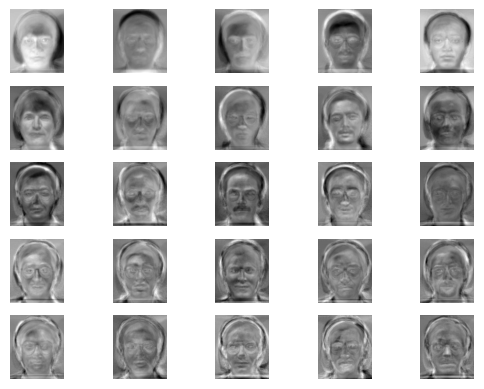

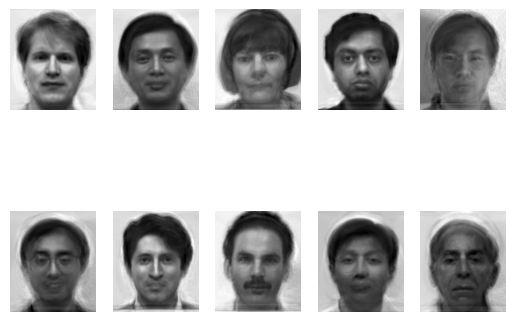


K= 1, PCA Accuracy: 83.33 % 
K= 2, PCA Accuracy: 83.33 % 
K= 3, PCA Accuracy: 83.33 % 
K= 4, PCA Accuracy: 86.67 % 
K= 5, PCA Accuracy: 90.00 % 
K= 6, PCA Accuracy: 86.67 % 
K= 7, PCA Accuracy: 90.00 % 
K= 8, PCA Accuracy: 83.33 % 
K= 9, PCA Accuracy: 80.00 % 
K= 10, PCA Accuracy: 80.00 % 
K= 11, PCA Accuracy: 80.00 % 
K= 12, PCA Accuracy: 80.00 % 

Average: 83.89 % 

PCA executed in: 9 seconds


In [9]:
# Reminder: SHAPE = (98, 116)
start_time = time.time()
PCA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, output_folder)
perprint(f"PCA executed in: {int(round(time.time() - start_time))} seconds")

## **Part 1_2 & 2_2: LDA**

X_pca.shape = (135, 126), and 126

Ratio (S_W^-1).S_B computed in 0 seconds
eigenvalue decomposition computed in 0 seconds 



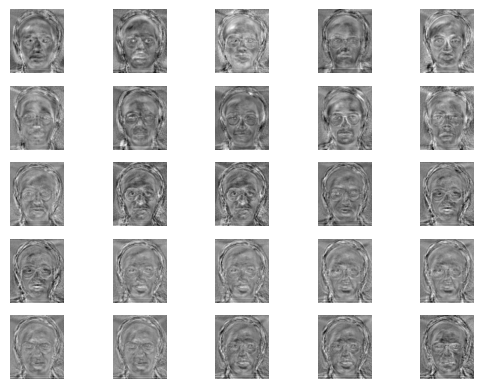

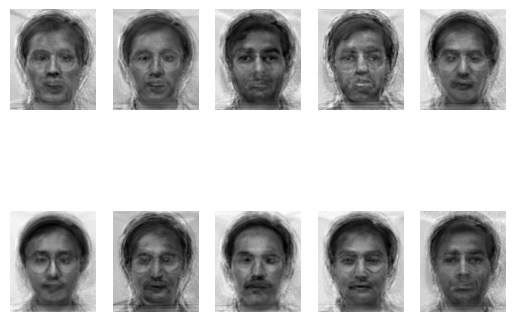


K= 1, LDA Accuracy: 100.00 % 
K= 2, LDA Accuracy: 100.00 % 
K= 3, LDA Accuracy: 100.00 % 
K= 4, LDA Accuracy: 100.00 % 
K= 5, LDA Accuracy: 100.00 % 
K= 6, LDA Accuracy: 100.00 % 
K= 7, LDA Accuracy: 100.00 % 
K= 8, LDA Accuracy: 100.00 % 
K= 9, LDA Accuracy: 100.00 % 
K= 10, LDA Accuracy: 100.00 % 
K= 11, LDA Accuracy: 100.00 % 
K= 12, LDA Accuracy: 100.00 % 

Average: 100.00 % 

LDA executed in: 10 seconds


In [10]:
# Reminder: SHAPE = (98, 116)
"""
In the next cell named "LDA Performance VS Top PCA Eigenvectors",
I determined that max accuracy is achieved when I choose the top 126
eigenvectors for initial dimensionality reduction before LDA.
"""
start_time = time.time()
initial_dim_reduction = 126
LDA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, output_folder, initial_dim_reduction)
perprint(f"LDA executed in: {int(round(time.time() - start_time))} seconds")

### LDA Performance VS Top PCA Eigenvectors

Top =   100 & Average = 95.00 %, and leng(averages) = 76, and executed in 5 seconds
Top =   200 & Average = 13.89 %, and leng(averages) = 176, and executed in 10 seconds
Top =   299 & Average = 13.33 %, and leng(averages) = 275, and executed in 15 seconds
LDA executed in: 30 seconds 

Max Accuracy = 100.00%, when Top = 126 



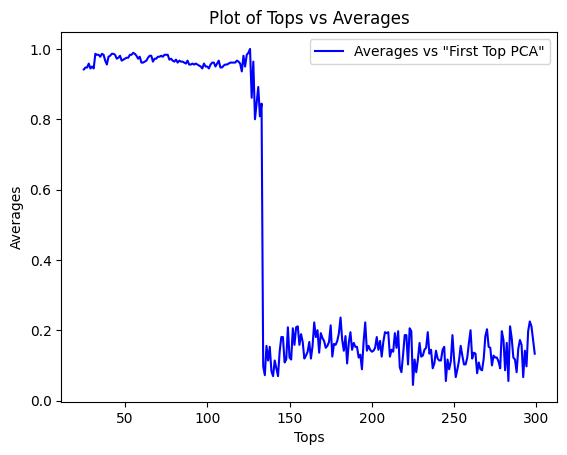

In [ ]:

def face_recognition__(train_labels, train_projections, test_labels, test_projections, k=5, title=''):
    error = 0
    dist = np.zeros(len(train_projections))
    for i in range(len(test_projections)):
        dist = cdist([test_projections[i]], train_projections, 'sqeuclidean')
        k_nearest = np.argsort(dist)[0][0:k]
        predict = np.argmax(np.bincount(train_labels[k_nearest]))
        if test_labels[i] != predict:
            error += 1
    accuracy = (len(test_labels) - error) / len(test_labels)
    return accuracy


def LDA__(train_images_centered, test_faces_centered, eigen_vectors_pca, train_labels, test_labels, SHAPE, top):
    top_eigen_vectors_pca = eigen_vectors_pca[:, 0:top]
    X_pca = np.dot(train_images_centered, top_eigen_vectors_pca) # eigenface.T = top_eigen_vectors_pca
    num_classes = len(np.unique(train_labels))
    num_features = X_pca.shape[1]  # = 25
    S_W = np.zeros((num_features, num_features))
    S_B = np.zeros((num_features, num_features))
    overall_mean = np.mean(X_pca, axis=0)
    for i in range(1, num_classes+1): # Be careful with the range
        class_indices = np.where(train_labels == i)[0]
        X_class = X_pca[class_indices]
        class_mean = np.mean(X_class, axis=0)
        S_W += np.dot((X_class - class_mean).T, (X_class - class_mean))
        N_i = X_class.shape[0]
        mean_diff = (class_mean - overall_mean).reshape(num_features, 1)
        S_B += N_i * (mean_diff).dot(mean_diff.T)
    ratio_B_W = np.dot( np.linalg.inv(S_W), S_B)
    eigen_values_lda, eigen_vectors_lda = np.linalg.eig(ratio_B_W) # Can comment out (1)
    sort_index_lda = np.argsort(-eigen_values_lda)
    top_eigen_vectors_lda  = eigen_vectors_lda[:, sort_index_lda[0:25]].real # Projection matrix W
    fisherfaces = np.dot(top_eigen_vectors_pca, top_eigen_vectors_lda) ########## Remove X_pca and put back top_eigen_vectors_pca
    fisherfaces = fisherfaces.T # Shape = (25, SHAPE[0]*SHAPE[1])
    train_projections = np.dot(train_images_centered, fisherfaces.T)
    test_projections = np.dot(test_faces_centered, fisherfaces.T)
    accuracy_list = []  # List to store accuracies for each k_neighbors
    for k_neighbors in range(1, 13):
        accuracy = face_recognition__(train_labels, train_projections, test_labels, test_projections, k_neighbors, title='LDA ')
        accuracy_list.append(accuracy)
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    return average_accuracy


if __name__ == "__main__":
    ''' Calculate the average face from training images '''
    avg_face = np.mean(train_images, axis=0)
    ''' Center the training images '''
    train_images_centered = train_images - avg_face
    test_faces_centered = test_images - avg_face
    # Load and Select the top 25 PCA eigenvectors
    eigen_vectors_pca = np.load(os.path.join(output_folder, "PCA_eigen_vectors.npy"))
    eigen_values_pca = np.load(os.path.join(output_folder, "PCA_eigen_values.npy"))
    sort_index_pca = np.argsort(-eigen_values_pca)
    eigen_vectors_pca = eigen_vectors_pca[:, sort_index_pca]

    tops = np.arange(25, 300)
    averages = []
    # Reminder: SHAPE = (98, 116)
    start_time = time.time()
    start_loop = time.time()

    for top in tops:
        result = LDA__(train_images_centered, test_faces_centered, eigen_vectors_pca, train_labels, test_labels, SHAPE, top)
        averages.append(result)
        if top % 100 == 0:
            perprint(f"Top = {top:5d} & Average = {result*100:03.2f} %, and leng(averages) = {len(averages)}, and executed in {int(round(time.time() - start_loop))} seconds")
            start_loop = time.time()
    perprint(f"Top = {top:5d} & Average = {result*100:03.2f} %, and leng(averages) = {len(averages)}, and executed in {int(round(time.time() - start_loop))} seconds")

    averages = np.array(averages)
    perprint(f"LDA executed in: {int(round(time.time() - start_time))} seconds \n")

    # Get the indices of all maximum values
    max_indices = np.where(averages == np.max(averages))[0]

    # Get the corresponding top values and maximum accuracy
    max_tops = tops[max_indices]
    max_accuracy = averages[max_indices]

    for i in max_indices:
      print(f"Max Accuracy = {averages[i]*100:.2f}%, when Top = {tops[i]} \n")

    # Plotting
    plt.plot(tops[:len(averages)], averages, label='Averages vs "First Top PCA"', color='blue')
    plt.xlabel('Tops')
    plt.ylabel('Averages')
    plt.title('Plot of Tops vs Averages')
    plt.legend()
    file_path = os.path.join(output_folder, f'Z_LDA_Different_Top_PCA.png')
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.show()


## **Part 3_1: Kernel PCA**


Found eigenvalues and eigenvectors for linear PCA kernel. 
Loading ... 



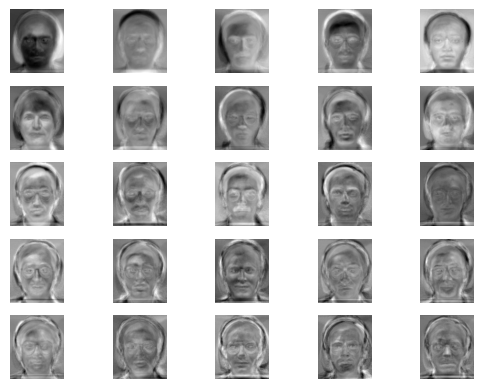

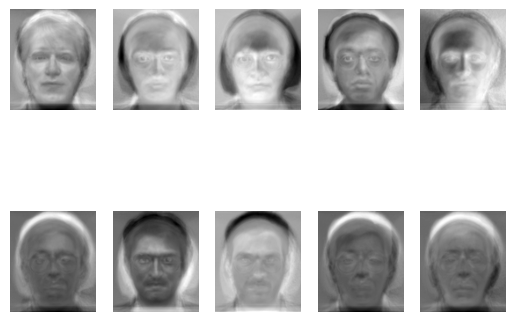

K= 1, linear_PCA Accuracy: 80.00 % 
K= 2, linear_PCA Accuracy: 80.00 % 
K= 3, linear_PCA Accuracy: 83.33 % 
K= 4, linear_PCA Accuracy: 83.33 % 
K= 5, linear_PCA Accuracy: 83.33 % 
K= 6, linear_PCA Accuracy: 83.33 % 
K= 7, linear_PCA Accuracy: 80.00 % 
K= 8, linear_PCA Accuracy: 80.00 % 
K= 9, linear_PCA Accuracy: 83.33 % 
K= 10, linear_PCA Accuracy: 83.33 % 
K= 11, linear_PCA Accuracy: 83.33 % 
K= 12, linear_PCA Accuracy: 83.33 % 

Average: 82.22 % 

Linear kernel PCA executed in: 2 seconds


Found eigenvalues and eigenvectors for polynomial PCA kernel. 
Loading ... 



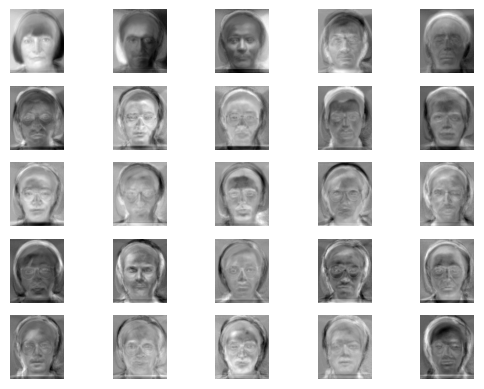

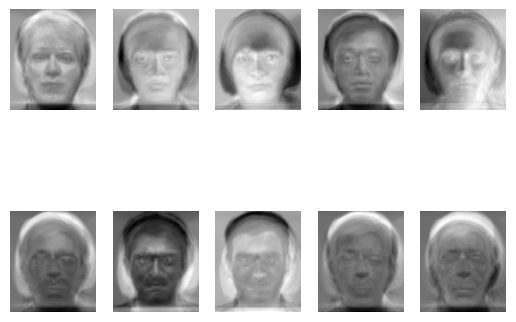

K= 1, polynomial_PCA Accuracy: 60.00 % 
K= 2, polynomial_PCA Accuracy: 63.33 % 
K= 3, polynomial_PCA Accuracy: 63.33 % 
K= 4, polynomial_PCA Accuracy: 63.33 % 
K= 5, polynomial_PCA Accuracy: 60.00 % 
K= 6, polynomial_PCA Accuracy: 53.33 % 
K= 7, polynomial_PCA Accuracy: 56.67 % 
K= 8, polynomial_PCA Accuracy: 53.33 % 
K= 9, polynomial_PCA Accuracy: 53.33 % 
K= 10, polynomial_PCA Accuracy: 53.33 % 
K= 11, polynomial_PCA Accuracy: 60.00 % 
K= 12, polynomial_PCA Accuracy: 56.67 % 

Average: 58.06 % 

Polynomial kernel PCA executed in: 2 seconds


Found eigenvalues and eigenvectors for rbf PCA kernel. 
Loading ... 



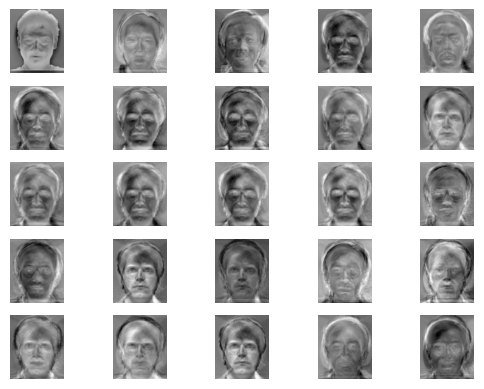

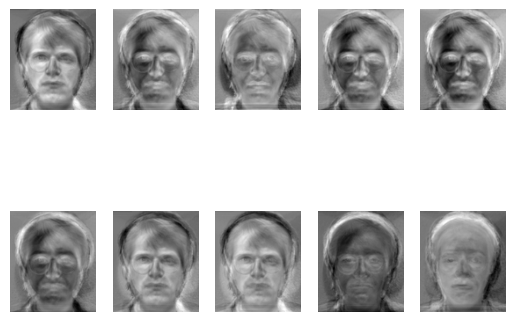

K= 1, rbf_PCA Accuracy: 16.67 % 
K= 2, rbf_PCA Accuracy: 16.67 % 
K= 3, rbf_PCA Accuracy: 13.33 % 
K= 4, rbf_PCA Accuracy: 10.00 % 
K= 5, rbf_PCA Accuracy: 13.33 % 
K= 6, rbf_PCA Accuracy: 13.33 % 
K= 7, rbf_PCA Accuracy: 10.00 % 
K= 8, rbf_PCA Accuracy: 10.00 % 
K= 9, rbf_PCA Accuracy: 6.67 % 
K= 10, rbf_PCA Accuracy: 6.67 % 
K= 11, rbf_PCA Accuracy: 6.67 % 
K= 12, rbf_PCA Accuracy: 6.67 % 

Average: 10.83 % 

RBF kernel PCA executed in: 2 seconds



In [13]:
# Reminder: SHAPE = (98, 116)
start_time = time.time()
kernel_PCA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, 'linear', output_folder)
perprint(f"Linear kernel PCA executed in: {int(round(time.time() - start_time))} seconds\n")

start_time = time.time()
kernel_PCA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, 'polynomial', output_folder)
perprint(f"Polynomial kernel PCA executed in: {int(round(time.time() - start_time))} seconds\n")

start_time = time.time()
kernel_PCA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, 'rbf', output_folder)
perprint(f"RBF kernel PCA executed in: {int(round(time.time() - start_time))} seconds\n")

## **Part 3_2: Kernel LDA**


Found eigenvalues and eigenvectors for linear LDA kernel. 
Loading ... 



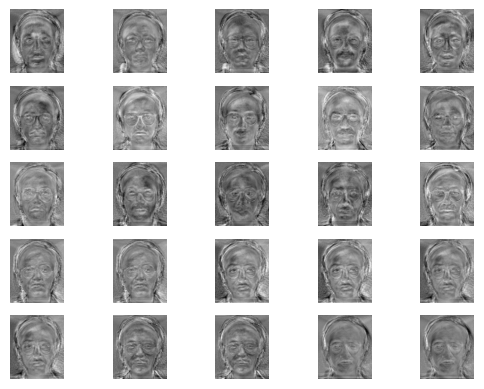

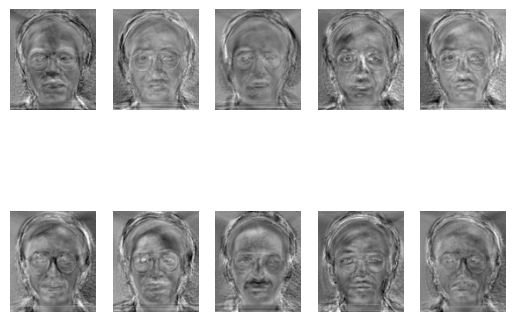


K= 1, linear LDA Accuracy: 86.67 % 
K= 2, linear LDA Accuracy: 86.67 % 
K= 3, linear LDA Accuracy: 86.67 % 
K= 4, linear LDA Accuracy: 86.67 % 
K= 5, linear LDA Accuracy: 86.67 % 
K= 6, linear LDA Accuracy: 86.67 % 
K= 7, linear LDA Accuracy: 86.67 % 
K= 8, linear LDA Accuracy: 86.67 % 
K= 9, linear LDA Accuracy: 86.67 % 
K= 10, linear LDA Accuracy: 86.67 % 
K= 11, linear LDA Accuracy: 86.67 % 
K= 12, linear LDA Accuracy: 86.67 % 

Average: 86.67 % 

Linear kernel LDA executed in: 4 seconds


Found eigenvalues and eigenvectors for polynomial LDA kernel. 
Loading ... 



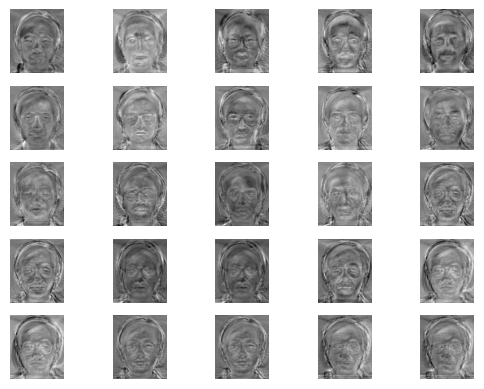

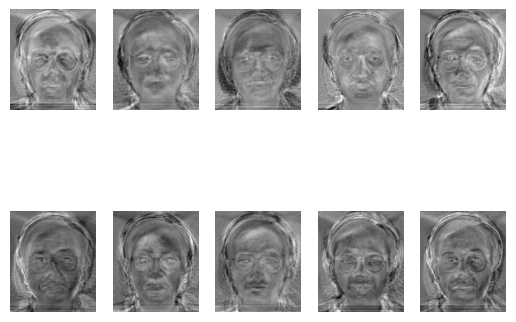


K= 1, polynomial LDA Accuracy: 86.67 % 
K= 2, polynomial LDA Accuracy: 90.00 % 
K= 3, polynomial LDA Accuracy: 86.67 % 
K= 4, polynomial LDA Accuracy: 86.67 % 
K= 5, polynomial LDA Accuracy: 90.00 % 
K= 6, polynomial LDA Accuracy: 90.00 % 
K= 7, polynomial LDA Accuracy: 93.33 % 
K= 8, polynomial LDA Accuracy: 90.00 % 
K= 9, polynomial LDA Accuracy: 90.00 % 
K= 10, polynomial LDA Accuracy: 93.33 % 
K= 11, polynomial LDA Accuracy: 93.33 % 
K= 12, polynomial LDA Accuracy: 96.67 % 

Average: 90.56 % 

Polynomial kernel LDA executed in: 4 seconds


Found eigenvalues and eigenvectors for rbf LDA kernel. 
Loading ... 



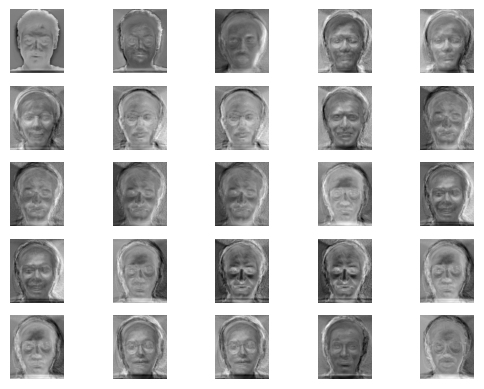

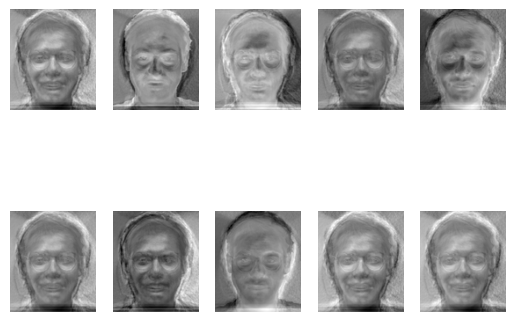


K= 1, rbf LDA Accuracy: 66.67 % 
K= 2, rbf LDA Accuracy: 63.33 % 
K= 3, rbf LDA Accuracy: 63.33 % 
K= 4, rbf LDA Accuracy: 63.33 % 
K= 5, rbf LDA Accuracy: 60.00 % 
K= 6, rbf LDA Accuracy: 60.00 % 
K= 7, rbf LDA Accuracy: 60.00 % 
K= 8, rbf LDA Accuracy: 56.67 % 
K= 9, rbf LDA Accuracy: 56.67 % 
K= 10, rbf LDA Accuracy: 53.33 % 
K= 11, rbf LDA Accuracy: 50.00 % 
K= 12, rbf LDA Accuracy: 53.33 % 

Average: 58.89 % 

RBF kernel LDA executed in: 6 seconds



In [12]:
# Reminder: SHAPE = (98, 116)
start_time = time.time()
kernel_LDA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, 'linear', output_folder)
perprint(f"Linear kernel LDA executed in: {int(round(time.time() - start_time))} seconds\n")

start_time = time.time()
kernel_LDA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, 'polynomial', output_folder)
perprint(f"Polynomial kernel LDA executed in: {int(round(time.time() - start_time))} seconds\n")

start_time = time.time()
kernel_LDA(train_images, test_images, train_labels, test_labels, SHAPE, chosen_index, 'rbf', output_folder)
perprint(f"RBF kernel LDA executed in: {int(round(time.time() - start_time))} seconds\n")

# **II. t-SNE**

## **Install this first to avoid package issue later**

In [ ]:
pip install --upgrade seaborn matplotlib imageio

## **Paths and directories for input and output files!**

In [ ]:

""" II. t-SNE """
import os
# Input directory
input_dir = "HMW_07/tsne_python/tsne_python"

# Output directory
output_dir = "HMW_07/t_sym_sne_output"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)


## **Import Packages!**

In [ ]:
import time ### New
import numpy as np
#import pylab # removed
import imageio.v2 as imageio ### New
import seaborn as sns ### New
import matplotlib.pyplot as plt ### New
from IPython.display import Image, display ### New
from scipy.spatial.distance import cdist ### New


## **All functions!**

In [21]:


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    # D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    D = cdist(X, X, 'sqeuclidean')  ### New, replaced above
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))

    # Sort the eigenvalues and eigenvectors in descending order of eigenvalues
    idx = l.argsort()[::-1]   ### New
    l = l[idx]                ### New
    M = M[:, idx]             ### New

    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def plotResult(Y, labels, idx, interval, method, perplexity, directory):
    plt.clf()
    scatter = plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
    plt.legend(*scatter.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5), title='Digit')

    ''' Annotate points with labels in the center of each cluster '''
    for label in set(labels):
        indices = labels == label
        center_x = np.mean(Y[indices, 0])
        center_y = np.mean(Y[indices, 1])
        plt.text(center_x, center_y, str(int(label)), fontsize=20, fontweight='bold', ha='center', va='center', color='k')

    plt.title(f'{method}, perplexity: {perplexity}, iteration: {idx}')
    plt.tight_layout()

    if interval:
        plt.savefig(os.path.join(directory, f"{method}_perplexity_{perplexity}_Y_{idx // interval:03d}.png"))
    else:
        plt.savefig(os.path.join(directory, f"{method}_perplexity_{perplexity}_Y_{idx}.png"))
        plt.show()

    return


def mode_tsne(directory, mode, interval, labels, X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE and symmetric SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real     # Make it more manageable for t-SNE
    (n, d) = X.shape

    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01

    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    if mode == 't-SNE':
        P = P * 4.									# early exaggeration
    elif mode == 'sym-SNE':
        P = P * 2.									# early exaggeration
    ''' Avoiding Numerical Instability '''
    P = np.maximum(P, 1e-12)

    # Run iterations
    num_fig = 0
    for iter in range(max_iter):

        # Compute pairwise affinities
        if mode == 't-SNE':
            """
            sum_Y = np.sum(np.square(Y), 1)
            num = -2. * np.dot(Y, Y.T)
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
            """
            num = 1 / (1 + cdist(Y, Y, 'sqeuclidean'))    ### New, replaced above
        elif mode == 'sym-SNE':
            num = np.exp(-1 * cdist(Y, Y, 'sqeuclidean'))   ### New

        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        if mode == 't-SNE':
            for i in range(n):
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)
        elif mode == 'sym-SNE':
            for i in range(n):
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain      # Or gains = np.maximum(gains, min_gain)
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if iter % interval == 0:
            num_fig += 1
            plotResult(Y, labels, iter, interval, mode, perplexity, directory)

        # Compute current value of cost function
        if (iter + 1) % interval == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            if mode == 't-SNE':
                P = P / 4.
            elif mode == 'sym-SNE':
                P = P / 2.

    # Return solution
    return Y, P, Q, num_fig


# Function for saving GIF images
def compose_gif(method, number_images, directory):
    ''' Temporary list to save the images read in directory'''
    gif_images = []

    ''' Iterate to read images '''
    for i in range(number_images):
        ''' Path of image '''
        gif_image_path = os.path.join(directory, f"{method}_perplexity_{perplexity}_Y_{i:03d}.png")
        ''' Read image into the list '''
        gif_images.append(imageio.imread(gif_image_path))
        os.remove(gif_image_path)

    ''' Add final image '''
    gif_image_path = os.path.join(directory, f"{method}_perplexity_{perplexity}_Y_final.png")
    gif_images.append(imageio.imread(gif_image_path))

    ''' Transform and save list as GIF inside the directory '''
    gif_image_path = os.path.join(output_dir, f"{method}_perplexity_{perplexity}.gif")
    imageio.mimsave(gif_image_path, gif_images, fps=10)


def plot_High_Dim_Low_Dim(P, Q, method, perplexity, directory):
    pal = sns.light_palette('blue', as_cmap=True)

    plt.figure()
    plt.title('High-Dimension Similarities')
    plt.imshow(P, cmap='cividis', interpolation='nearest')
    plt.clim()  # Set color limits
    plt.savefig(os.path.join(directory, f"{method}_perplexity_{perplexity}_High-Dim.png"))
    plt.show()

    plt.figure()
    plt.title('Low-Dimension Similarities')
    plt.imshow(Q, cmap='cividis', interpolation='nearest')
    plt.clim()  # Set color limits
    plt.savefig(os.path.join(directory, f"{method}_perplexity_{perplexity}_Low-Dim.png"))
    plt.show()


def show_existing_images(directory, method, perplexity):
    final_image_path = os.path.join(directory, f"{method}_perplexity_{perplexity}_Y_final.png")
    high_D_image_path = os.path.join(directory, f"{method}_perplexity_{perplexity}_High-Dim.png")
    low_D_image_path = os.path.join(directory, f"{method}_perplexity_{perplexity}_Low-Dim.png")
    paths = [final_image_path, high_D_image_path, low_D_image_path]
    for path in paths:
        try:
            display(Image(filename = path))
        except FileNotFoundError:
            print(f"\nThe file {path} does not exist.\n")
        except Exception as e:
            print(f"\nAn error occurred: {e}\n")
    print()



## **Load training and testing data**

In [22]:

X = np.loadtxt(os.path.join(input_dir, "mnist2500_X.txt"))
labels = np.loadtxt(os.path.join(input_dir, "mnist2500_labels.txt"))


## **Part 1, 2, 3 & 4**

In [23]:

if __name__ == "__main__":

    interval = 10
    perplexities = [5., 20., 30., 40., 50., 100.]
    methods = ['t-SNE', 'sym-SNE']
    for method in methods:
        for perplexity in perplexities:
            print(f"\nPerform {method} on MNIST dataset.")
            print(f"Running example on 2,500 MNIST digits for perplexity = {perplexity}...\n")

            gif_image_path = os.path.join(output_dir, f"{method}_perplexity_{perplexity}.gif")

            Y, P, Q, number_images = mode_tsne(output_dir, method, interval, labels, X, 2, 50, perplexity)
            print(f"number_images= {number_images}\n")
            plotResult(Y, labels, 'final', None, method, perplexity, output_dir)
            compose_gif(method, number_images, output_dir)
            plot_High_Dim_Low_Dim(P, Q, method, perplexity, output_dir)

            # Can change the frame rate with this:
            """
            # Desired frame rate (replace 10 with your preferred frame rate)
            new_frame_rate = 5 # Default is 10

            # Read the input GIF
            gif = imageio.mimread(gif_image_path)

            # Write the output GIF with the new frame rate
            imageio.mimsave(gif_image_path, gif, fps = new_frame_rate)
            """



Perform t-SNE on MNIST dataset.
Running example on 2,500 MNIST digits for perplexity = 5.0...

It has already been done. 
Displaying results ... 


An error occurred: 'module' object is not callable


An error occurred: 'module' object is not callable


An error occurred: 'module' object is not callable



Perform t-SNE on MNIST dataset.
Running example on 2,500 MNIST digits for perplexity = 20.0...

It has already been done. 
Displaying results ... 


An error occurred: 'module' object is not callable


An error occurred: 'module' object is not callable


An error occurred: 'module' object is not callable



Perform t-SNE on MNIST dataset.
Running example on 2,500 MNIST digits for perplexity = 30.0...

It has already been done. 
Displaying results ... 


An error occurred: 'module' object is not callable


An error occurred: 'module' object is not callable


An error occurred: 'module' object is not callable



Perform t-SNE on MNIST dataset.
Running example on 2,500 MNIST digits for

# **End of coding**

In [ ]:
perprint("\n\nEnd")
# Close the output file at the end of your code
output_file.close()



End
